In [3]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.1 MB/s eta 0:00:00


In [4]:
import io
import os
import numpy as np
import seaborn as sns
sns.set()

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import matplotlib as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from distutils.version import LooseVersion as LV
from sklearn.metrics import *
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef

In [5]:
#read dataset with emotions column
df = pd.read_csv("AdvancedDataset.csv")

In [6]:
df.head()

,Unnamed: 0,Toxicity,tweet,tweet_clean,tweet_tokenized,tweet_tok=2,tweet_lemmatized,preprocessed_text,emotion
0,0,0,@user when a father is dysfunctional and is so...,father dysfunctional selfish drags kids dysfun...,"['father', 'dysfunctional', 'selfish', 'drags'...","[('father', 'dysfunctional'), ('dysfunctional'...","['father', 'dysfunctional', 'selfish', 'drag',...",father dysfunctional selfish drag kid dysfunct...,neutral
1,1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit can not use cause do not ...,"['thanks', 'lyft', 'credit', 'can', 'not', 'us...","[('thanks', 'lyft'), ('lyft', 'credit'), ('cre...","['thank', 'lyft', 'credit', 'can', 'not', 'use...",thank lyft credit can not use cause do not off...,disappointment
2,2,0,bihday your majesty,bihday majesty,"['bihday', 'majesty']","[('bihday', 'majesty')]","['bihday', 'majesty']",bihday majesty,neutral
3,3,0,factsguide: society now #motivation,factsguide society motivation,"['factsguide', 'society', 'motivation']","[('factsguide', 'society'), ('society', 'motiv...","['factsguide', 'society', 'motivation']",factsguide society motivation,neutral
4,4,0,[2/2] huge fan fare and big talking before the...,huge fan fare big talking leave chaos pay disp...,"['huge', 'fan', 'fare', 'big', 'talking', 'lea...","[('huge', 'fan'), ('fan', 'fare'), ('fare', 'b...","['huge', 'fan', 'fare', 'big', 'talk', 'leave'...",huge fan fare big talk leave chaos pay dispute...,neutral


In [7]:
#emotions visualization and associated counting
#there are 28 emotions
df['emotion'].value_counts()

neutral           24426
anger              8299
joy                2760
amusement          2543
love               2289
admiration         1902
excitement         1750
disgust            1214
gratitude          1119
approval            715
sadness             714
annoyance           669
caring              662
disapproval         469
fear                466
surprise            437
desire              321
optimism            281
disappointment      216
realization         199
nervousness         163
pride               127
remorse             119
confusion           101
embarrassment        70
relief               55
curiosity            51
grief                39
Name: emotion, dtype: int64

In [8]:
#we use preprocessed_text because it is also lemmatized
#fillna() replaces possible Null values in preprocessed_text column 
df['preprocessed_text']=df['preprocessed_text'].fillna("")

In [11]:
# Encoding target variable
encoder = LabelEncoder()
X = df['preprocessed_text']
y = encoder.fit_transform(df["emotion"]) 
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

In [13]:
# Transform target in tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

TEXT PROCESSING PER BERT
(1) Tokenize the sentence.
(2) Map tokens to their IDs.
(3) Prepend the `[CLS]` token to the start. Append the `[SEP]` token to the end.
(4) Pad or truncate the sentence to `max_length`
(5) Create attention masks for [PAD] tokens.
Function tokenizer.encode_plus was used which encapsulates the whole procedure

In [14]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Example for a tweet 
print("Tokenized tweet: ", tokenizer.tokenize(X_train.values[0]))
print("Original tweet: ", X_train.values[0])

Tokenized tweet:  ['many', 'al', '##um', 'friend', 'wake', 'shock', 'hear', 'death', 'sc', '##su', 'president', 'shock']
Original tweet:  many alum friend wake shock hear death scsu president shock 


In [16]:
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train.values[0])))

Token IDs:  [2116, 2632, 2819, 2767, 5256, 5213, 2963, 2331, 8040, 6342, 2343, 5213]


In [17]:
#Example complete:
#To be properly handled by BERT we need to add the [CLS] token at the beginning of text. The [SEP] token is another special token required by BERT at the end of the sentence.
sentence = X_train.values[0]
tokens_ = tokenizer.tokenize(sentence)
tokens_ = ['[CLS]'] + tokens_ + ['[SEP]']
print("Tokenized tweet: ", tokens_)
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokens_))

Tokenized tweet:  ['[CLS]', 'many', 'al', '##um', 'friend', 'wake', 'shock', 'hear', 'death', 'sc', '##su', 'president', 'shock', '[SEP]']
Token IDs:  [101, 2116, 2632, 2819, 2767, 5256, 5213, 2963, 2331, 8040, 6342, 2343, 5213, 102]


RICERCA MAX LENGTH TRAIN & TEST

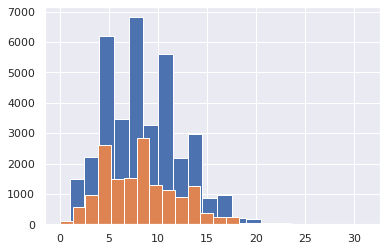

In [18]:
#Now let's set the maximum sequence lengths for our training and test sentences as MAX_LEN_TRAIN and MAX_LEN_TEST.
#The maximum length supported by the BERT model used is 128 and 512.
#But we are looking for the maxim suitable for the task --> I take the sentences and divide them to find how many words they are composed of --> it is the length of the sentence
#if we do it for each sentence then we see which one is the longest and we take this length as the maximum value

train = [len(i.split()) for i in X_train]
test = [len(i.split()) for i in X_test]

for i in [train, test]:
  pd.Series(i).hist(bins=20)

In [19]:
#chosen length
MAX_LENGTH = 25

Next we use the BERT tokenizer to convert each token into an integer index into the BERT vocabulary. We also pad the shorter sequences with the indices "MAX_LEN_TRAIN" or "MAX_LEN_TEST" (the two LENs are both equal to MAX_LENGTH) with trailing zeros.
BERT also requires *attention masks*, with 1 for each real token in the sequences and 0 for padding.

In [20]:
#function definition
def prepare_data(data, max_len):
  inputs_ = []
  attention_mask = []
  for tweet in data:
    encoded_dict = tokenizer.encode_plus(
      tweet, #tweet to encode = (tokenize + add special character)
      add_special_tokens = True, # Add [CLS] for specify classification task and [SEP]
      max_length = max_len,
      pad_to_max_length  = True, #For pad & truncate all sentence
      return_attention_mask = True, # For return attention masks
      #return_tensors = 'pt' # Return pythorch tensors
    )
    # Select encoded sentence    
    inputs_.append(encoded_dict['input_ids'])

    # Select attention masks
    attention_mask.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.tensor(inputs_)
  attention_masks = torch.tensor(attention_mask)

  return input_ids, attention_masks

In [21]:
#function application
train_data, train_masks = prepare_data(X_train, MAX_LENGTH)
test_data, test_masks = prepare_data(X_test, MAX_LENGTH)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
#Prova: Print sentence 0, now as a list of IDs.
print('Original: ', X_train.values[0])
print('Token IDs:', train_data[0])
print('Attention Mask:', train_masks[0])

Original:  many alum friend wake shock hear death scsu president shock 
Token IDs: tensor([ 101, 2116, 2632, 2819, 2767, 5256, 5213, 2963, 2331, 8040, 6342, 2343,
        5213,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


In [23]:
#We use scikit-learn's train_test_split() to use 10% of our training data as a validation set.
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(train_data, train_labels,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(train_masks, train_data,
                          random_state=42, test_size=0.1)

We create PyTorch *DataLoader*s for all data sets.
For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [24]:
#chosen batch_size
BATCH_SIZE = 32

In [25]:
#function definition
def dataloader(input_ids, attention_masks, labels, name):
  dataset = TensorDataset(input_ids, attention_masks, labels) #Combine inputs in to a TensorDataset
  if name == "Train":
    sampler = RandomSampler(dataset)  # Select batches randomly
  else:
    sampler = SequentialSampler(dataset)  # Select batches sequentially
  data_loader = DataLoader(
            dataset,
            sampler = sampler,
            batch_size = BATCH_SIZE # Number of batchsize
  )
  print(f"{name} documents {len(dataset)}")
  return data_loader

In [26]:
#function application
train_dataloader = dataloader(train_inputs, train_masks, train_labels, "Train")
test_dataloader = dataloader(test_data, test_masks, test_labels, "Test")
val_dataloader = dataloader(validation_inputs, validation_masks, validation_labels, "Validation")

Train documents 32870
Test documents 15653
Validation documents 3653


In [27]:
# Function to calculate the accuracy of our predictions vs labels
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
"bert-base-uncased" = the 12-layer BERT model, with an uncased vocab.se the 12-layer BERT model, with an uncased vocabulary

In [28]:
#bert model initialization
BERTMODEL = "bert-base-uncased"

In [29]:
model = BertForSequenceClassification.from_pretrained(
    BERTMODEL, 
    num_labels = 28, #multiclass   
    output_attentions = False, 
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [30]:
#To run this model on the GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We set the remaining hyperparameters needed for fine-tuning the pretrained model: 
 * EPOCHS: the number of training epochs in fine-tuning
   (recommended values between 2 and 4) 
 * WEIGHT_DECAY: weight decay for the Adam optimizer 
 * LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended) 
 * WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate

We also need to grab the training parameters from the pretrained model.

In [32]:
#define optimizer Adam
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
#chosen number of epochs (it can be between 2 and 4)
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [34]:
#Tell PyTorch to use the GPU.    
device = torch.device("cuda")

In [35]:
training_stats = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device) #batch[0] - input_ids
        b_input_mask = batch[1].to(device) #batch[1] - attention_masks
        b_labels = batch[2].to(device) #batch[2] - labels

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs".
        model.zero_grad() 

        # Forward pass (for evaluate the model on this training batch)
        model1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels) 
        loss = model1.loss
        logits = model1.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()       


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)    

    print("\n \t Average training loss: {0:.2f}".format(avg_train_loss))
    
    
    # ========================================
    #               Validation PHASE 
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model2 = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = model2.loss
            logits = model2.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )


======== Epoch 1 / 2 ========
Training...

 	 Average training loss: 1.26
  Accuracy: 0.75
  Validation Loss: 0.93

======== Epoch 2 / 2 ========
Training...

 	 Average training loss: 0.81
  Accuracy: 0.76
  Validation Loss: 0.86


In [36]:
# Display floats with two decimal places.
pd.set_option('precision', 6)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,1.257435,0.925377,0.754674
2,0.805200,0.857091,0.759022


Evaluation on test

In [37]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  prediction = np.argmax(logits, axis=1)

  # Store predictions and true labels
  for i in prediction:
    predictions.append(i)
  for i in label_ids:
    true_labels.append(i)

In [38]:
#function definition for model evaluation
def model_evaluation(real_v, pred_v):
    print(f"Accuracy sore: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")

In [41]:
model_evaluation(true_labels, predictions)

Accuracy sore: 0.7555101258544688
Classification report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.64       571
           1       0.82      0.86      0.84       763
           2       0.74      0.87      0.80      2490
           3       0.50      0.00      0.01       201
           4       0.45      0.02      0.04       214
           5       0.51      0.24      0.32       198
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        15
           8       0.36      0.32      0.34        96
           9       0.80      0.06      0.11        65
          10       0.72      0.09      0.16       141
          11       0.50      0.53      0.51       364
          12       0.00      0.00      0.00        21
          13       0.66      0.52      0.58       525
          14       0.25      0.20      0.22       140
          15       0.81      0.86      0.84       336
          16       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
